
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Parameters


In [1]:

vocab_size = 1000

comment_exp = "tok_embMpos_embMconv_embMper_conv_emb"



## Experimental Details


In [2]:


exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.close()




## Libraries


In [3]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [4]:

import pandas as pd
import numpy as np


In [5]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [6]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [7]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [9]:

from einops import rearrange
from math import sqrt, log


In [10]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [11]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [12]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [13]:

device = "cpu"


In [14]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [15]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [16]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [18]:

pos_emb.shape


torch.Size([15, 512])

In [19]:

res = x_enc + pos_emb


In [20]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [21]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [22]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [23]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [24]:

for_RNN_data_CIVS


,Unnamed: 0,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,1,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,2,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,3,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,4,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,5,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1379,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,1380,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,1381,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,1382,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [25]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [26]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [27]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [28]:

for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Plots


In [29]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

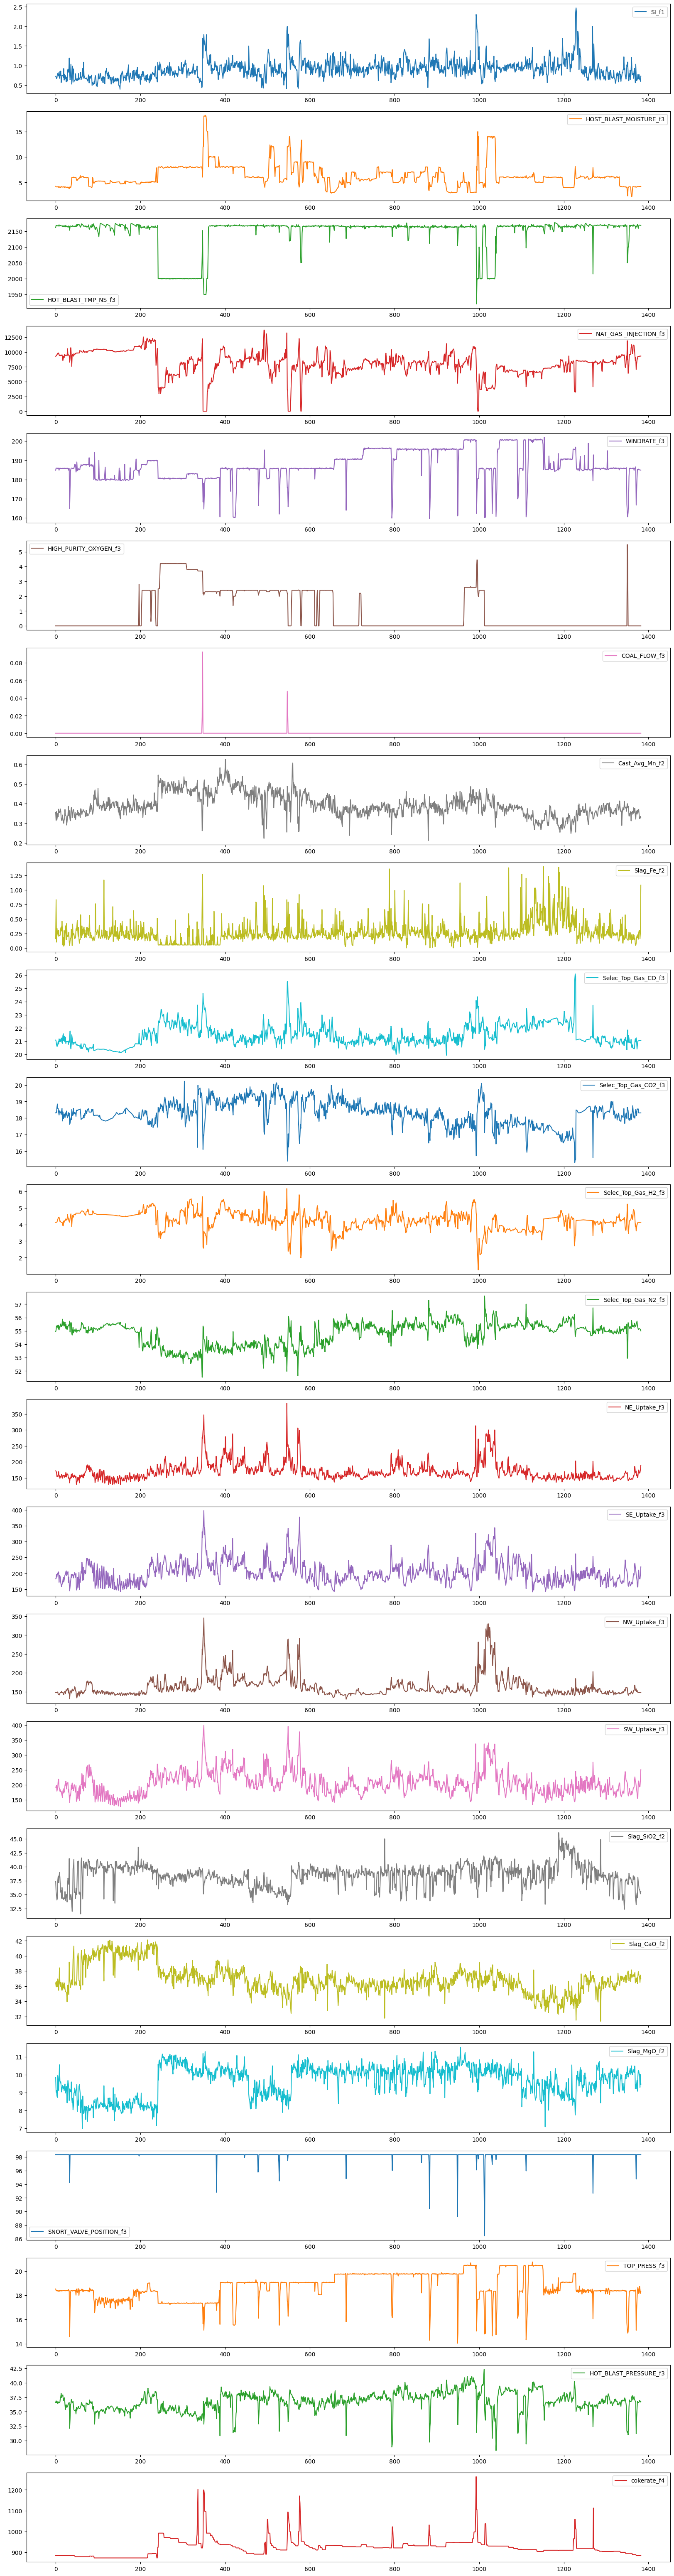

In [30]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [31]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [32]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [33]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [34]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [35]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [36]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [37]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [38]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [39]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [40]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [41]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [42]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [43]:

m = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
input2 = torch.randn(8, 4, 25)

input_permute = rearrange(input2, 'b l m -> b m l')
print( input_permute.shape )
input2 = input2.unsqueeze(1)
input_permute = input_permute.unsqueeze(1)
output = m(input_permute)
output.shape


torch.Size([8, 25, 4])


torch.Size([8, 1, 25, 4])

In [44]:

inputs = torch.randn( 64, 1, 300 ) 

module = torch.nn.Conv1d(
    in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False
)

## module.weight.data = torch.full_like( module.weight.data, 0.2 )

out = module(inputs)
out.shape


torch.Size([64, 1, 300])

In [45]:

## a = torch.tensor( 42.6 )

## torch.round(a).int().item()


In [46]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################

        self.map_24_512_1 = nn.Linear(25, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 512)  ## [24, 512] # projection
        
   
        #####################################

        self.linear1_TS_int = nn.Linear(25, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv_idx2     = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, bias=False) 
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv_idx3     = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2, bias=False) 

        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2, bias=False) 
        self.per_bn1 = nn.BatchNorm2d(16)
        self.per_relu1 = nn.ReLU(inplace=True)
        self.per_conv_idx2     = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, bias=False) 
        self.per_bn2 = nn.BatchNorm2d(32)
        self.per_relu2 = nn.ReLU(inplace=True)
        self.per_conv_idx3     = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )
        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = res

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################
        ## add this back - rc

        ## idx = self.map_24_512( idx )       ## (8, 15, 24) goes in
        ## idx = self.map_act(    idx )
        
        ## tok_emb = idx       ## (B, 15, 512)

        ###########################################################

        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx ) 
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        residual = idx_4d_conv
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = self.bn1(conv_emb)
        conv_emb = self.relu1(conv_emb)
        conv_emb = self.conv_idx2( conv_emb )
        conv_emb = self.bn2(conv_emb)
        conv_emb = self.relu2(conv_emb)
        conv_emb = self.conv_idx3( conv_emb)
        conv_emb = residual + conv_emb
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_residual = idx_4d_conv_permute
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = self.per_bn1(per_conv_emb)
        per_conv_emb = self.per_relu1(per_conv_emb)
        per_conv_emb = self.per_conv_idx2( per_conv_emb )
        per_conv_emb = self.per_bn2( per_conv_emb )
        per_conv_emb = self.per_relu2( per_conv_emb )
        per_conv_emb = self.per_conv_idx3( per_conv_emb )
        per_conv_emb = per_residual + per_conv_emb
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]


        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [47]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E )
        y_train        = yb.view(     B*T, E )

        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [48]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 1000   ## 5000
eval_interval     = 200     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2





## Utility Functions


In [49]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [50]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [51]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 14 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    find_index = index_to_slice + 395
    SI_data    = SI_lookup_for_RNN_data_CIVS.to_numpy()[ find_index:find_index+19, 0 ]  ## real SI data is here

    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    l_real = y_real_gpt[ :, 0 ]   
    l_pred = y_pred_gpt[ :, 0 ]

    l_SI_data_real = SI_data
    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]
    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()
    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[0:4] ), 
                          torch.FloatTensor( l_real[0:4] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[5:10] ), 
                          torch.FloatTensor( l_real[5:10] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[10:19] ), 
                          torch.FloatTensor( l_real[10:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    #######################################

    x = [ i for i in range(len(l_real)) ] 

    l_SI_data_pred = []
    ## www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    www3 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3            ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        ww4 = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1 + i, 0]
        the_curr_val = ww4 + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ########################################
    ## Plots

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    train_real_plot = train_plot[:, 0]
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    
    ##########################################

    x = [ i for i in range(len(l_real)) ] 

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()

    ###########################################
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, yellow_l_SI_data_pred, label = "pred1c", color='green')   ## yellow  ## ?? rc
    fig.tight_layout()
    ax[1].legend(); plt.show()

    return results_string 


In [52]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [53]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    results_string = GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )
    return results_string


In [54]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [55]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Delta of SI


In [56]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [57]:

delta_for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [58]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [59]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [60]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [61]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [62]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [63]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [64]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [65]:

delta_for_RNN_data_CIVS


,delta_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [66]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [67]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [68]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [69]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [70]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [71]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.000000,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.000000,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.000000,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.004444,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.008900,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,-0.037618,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,-0.014340,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [72]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [73]:

training_chunk = 400


In [74]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [75]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


304

In [76]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
304
719


In [77]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [78]:

sliced_chunk_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
304,-0.010336,0.009905,7.945657,2000.040850,7080.598304,180.534391,4.196492,0.0,0.499,0.05,22.392867,20.221886,4.499215,53.004470,193.706673,221.275626,178.876961,238.636236,37.669998,38.599998,10.87,98.334297,17.360033,34.824846,946.0
305,0.073658,0.017544,7.974594,1999.242412,8201.000884,180.557957,4.201026,0.0,0.516,0.10,22.320048,18.600412,4.727436,53.032211,179.736875,219.082152,166.309383,224.964983,38.660000,37.189999,10.45,98.334297,17.336626,35.144070,946.0
306,0.087234,0.025862,8.004604,2000.236270,8149.202638,180.704801,4.201803,0.0,0.511,0.07,21.894711,17.461756,5.015593,53.223138,195.709820,248.889170,173.724494,260.673348,37.139999,37.660000,10.36,98.334297,17.344073,34.619702,946.0
307,-0.115715,-0.005001,8.014720,1999.697648,6695.596958,180.389222,4.199302,0.0,0.515,0.05,22.157855,17.622424,4.511036,53.381336,215.543813,247.864816,186.825830,262.043605,38.580002,38.270000,10.97,98.334297,17.355028,35.408387,946.0
308,0.036334,0.026470,7.992973,1999.852272,5913.571369,180.553034,4.199435,0.0,0.489,0.05,22.440015,17.739470,4.076667,53.439793,169.583357,200.798708,159.724509,210.240721,37.369999,37.709999,10.23,98.334297,17.361799,34.978679,946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,0.070866,-0.027697,5.733306,2165.707626,7273.756136,190.439832,0.000000,0.0,0.336,0.46,21.122069,19.210661,3.822152,54.898974,157.291012,190.691174,155.132799,181.362516,38.049999,36.430000,10.09,98.334297,19.767529,36.667756,926.0
715,-0.154951,-0.024063,5.784293,2165.733410,7520.333662,190.601708,0.000000,0.0,0.353,0.44,21.359733,18.407514,3.937040,55.266125,162.232742,187.869310,159.557293,196.091465,38.200001,35.130001,9.61,98.334297,19.772604,36.086737,926.0
716,0.229184,0.015165,5.877097,2165.888682,7017.672342,190.680144,0.064988,0.0,0.328,0.27,20.693864,18.886890,3.743569,55.529396,152.992915,175.581664,151.360504,167.358856,39.520000,36.299999,10.37,98.334297,19.783748,36.278695,926.0
717,-0.137761,-0.008552,5.303141,2164.591537,7398.943663,190.582221,2.198176,0.0,0.345,0.27,21.990923,18.842844,3.691308,54.354598,159.424629,162.221500,147.361381,168.329149,38.980000,36.459999,10.39,98.334297,19.747974,37.626638,926.0



## Train and test


In [79]:

n = block_size

print( n )


15


In [80]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [81]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [82]:

test_CIVS 


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
704,0.316925,0.040416,7.065582,2163.992759,7065.554737,190.697686,0.000000,0.0,0.379,0.23,20.693986,19.097315,4.073560,54.980104,158.433680,193.529531,144.569960,193.239304,38.790001,37.139999,10.24,98.334297,19.773910,37.753597,927.000000
705,-0.191284,0.005738,7.068836,2168.165350,7308.900600,190.388108,0.000000,0.0,0.363,0.20,20.579040,19.031798,4.105431,55.131054,168.995795,190.741429,144.371339,200.730308,38.000000,36.849998,10.19,98.334297,19.776443,38.256911,927.000000
706,-0.163103,-0.047804,6.187604,2163.598928,7347.997824,190.761763,0.000000,0.0,0.383,0.15,20.975828,18.425664,4.084254,55.192831,165.161983,183.826703,144.184987,193.166323,38.020000,36.720001,10.17,98.334297,19.789807,36.996745,927.000000
707,0.099408,0.024160,6.854342,2163.940340,7057.784805,190.469380,0.000000,0.0,0.391,0.29,21.039993,18.405077,4.182016,55.107410,161.315684,187.869295,143.941916,202.431023,38.230000,35.950001,9.93,98.334297,19.756129,37.286602,927.000000
708,-0.055734,0.009204,6.883659,2163.349652,7048.824558,190.787292,0.000000,0.0,0.371,0.19,20.820919,18.522323,4.204281,55.228935,156.125040,190.204864,143.695646,199.081056,38.630001,36.349998,10.10,98.334297,19.775159,37.454336,927.000000
709,0.163453,0.018083,6.907644,2164.513268,7276.285401,190.559709,0.000000,0.0,0.390,0.29,20.739136,18.878285,4.375970,54.955687,152.167289,181.255778,143.494003,185.241558,39.000000,36.369999,10.23,98.334297,19.780388,37.452080,926.447552
710,-0.138491,-0.004483,5.717267,2165.614916,7274.481411,190.662620,0.000000,0.0,0.370,0.19,20.825816,18.552428,3.840427,55.593324,162.778176,176.191040,154.728330,187.878657,38.880001,36.310001,10.26,98.334297,19.780777,36.709885,926.000000
711,-0.144067,-0.018768,5.693732,2165.953047,7158.846052,190.422079,0.000000,0.0,0.371,0.27,21.091634,18.876331,3.789292,55.161263,164.216432,178.386442,154.386675,188.897978,39.419998,36.540001,10.50,98.334297,19.768105,36.547346,926.000000
712,0.319619,0.018729,5.673386,2165.631528,7439.023043,190.722187,0.000000,0.0,0.328,0.19,21.018956,18.794044,3.873000,55.271187,159.223440,188.976356,154.487622,193.344324,38.560001,35.880001,10.06,98.334297,19.754934,36.329439,926.000000
713,-0.237633,-0.003091,5.684292,2165.746555,7109.764738,190.898290,0.000000,0.0,0.377,0.20,20.885795,18.728105,3.832585,55.562234,155.850805,183.770399,153.342613,182.496352,37.970001,35.980000,9.97,98.334297,19.775006,36.355662,926.000000


In [83]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [84]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


In [85]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

'\nprint(idx.shape)\n        vals, indeces = torch.max( idx, dim=2  )\n        print( vals.shape )\n        print( indeces )\n        print(idx.shape)\n        input()\n'

torch.Size([100, 25])
0 train loss =  1.2832307815551758
500 train loss =  0.005178492981940508


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


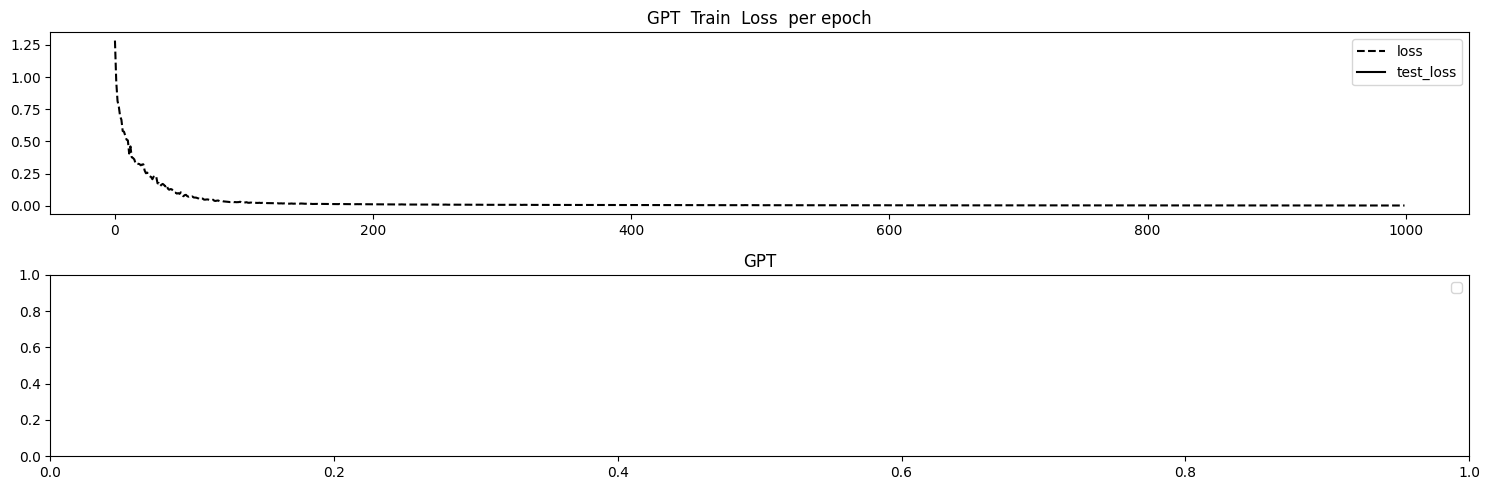

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03445308282971382
Test MSE Loss - SI only 0-5:  0.0030470683705061674
Test MSE Loss - SI only 5-10:  0.042402952909469604
Test MSE Loss - SI only 10-15:  0.0352519229054451
mae, mse, rmse, mape, mspe, rse, corr
(0.15170158, 0.034453083, 0.18561542, 4.8397427, 280.3649, 1.1077803)
Testing R**2 - SI only:  -0.22717726230621338
Testing R**2 - SI only:  -0.22717726230621338
Testing R**2 - All features:  0.9895824790000916


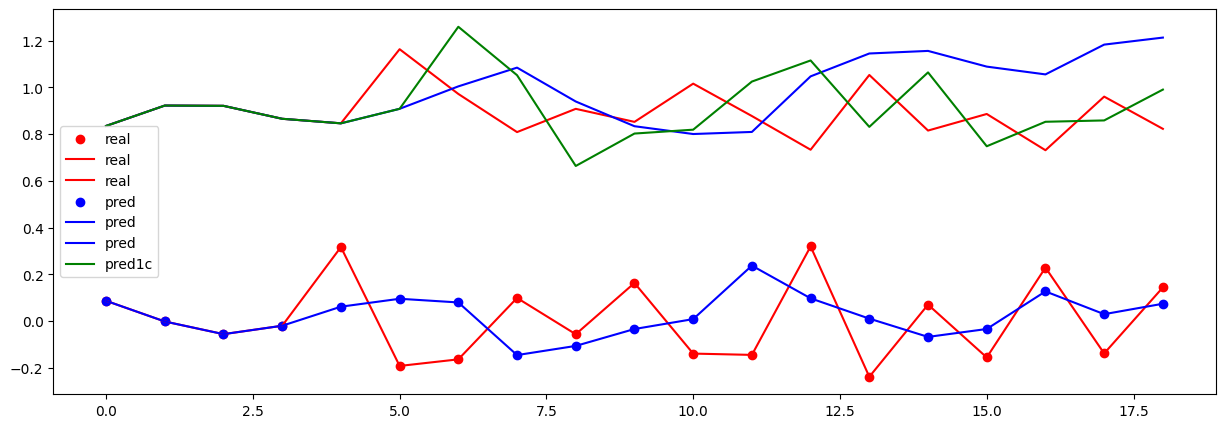

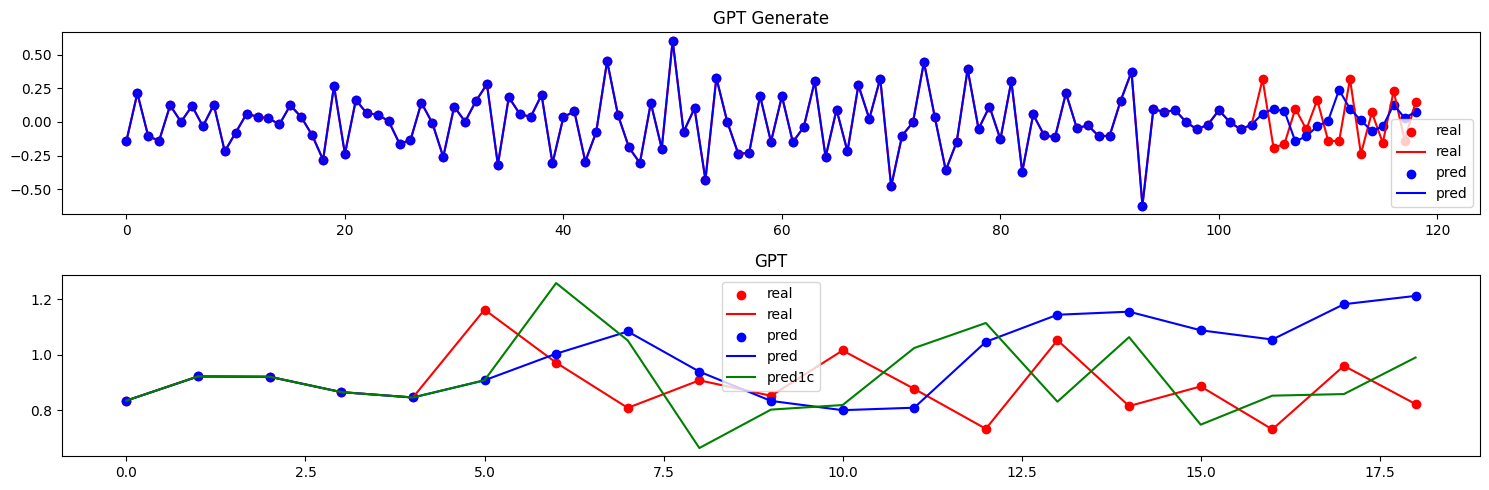

In [86]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


torch.Size([200, 25])
0 train loss =  1.4437236785888672
500 train loss =  0.008420569822192192


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


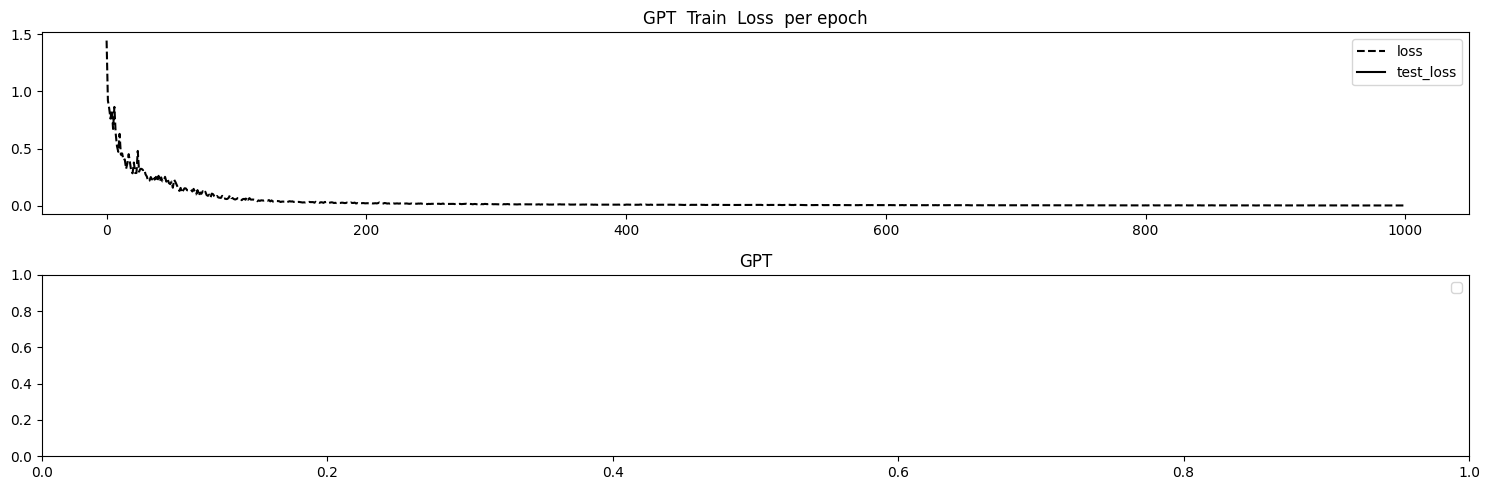

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.04436066374182701
Test MSE Loss - SI only 0-5:  0.0030470683705061674
Test MSE Loss - SI only 5-10:  0.04645780101418495
Test MSE Loss - SI only 10-15:  0.05391522869467735
mae, mse, rmse, mape, mspe, rse, corr
(0.17022693, 0.04436066, 0.2106197, 5.0127363, 281.18652, 1.2570096)
Testing R**2 - SI only:  -0.5800731182098389
Testing R**2 - SI only:  -0.5800731182098389
Testing R**2 - All features:  0.9300174713134766


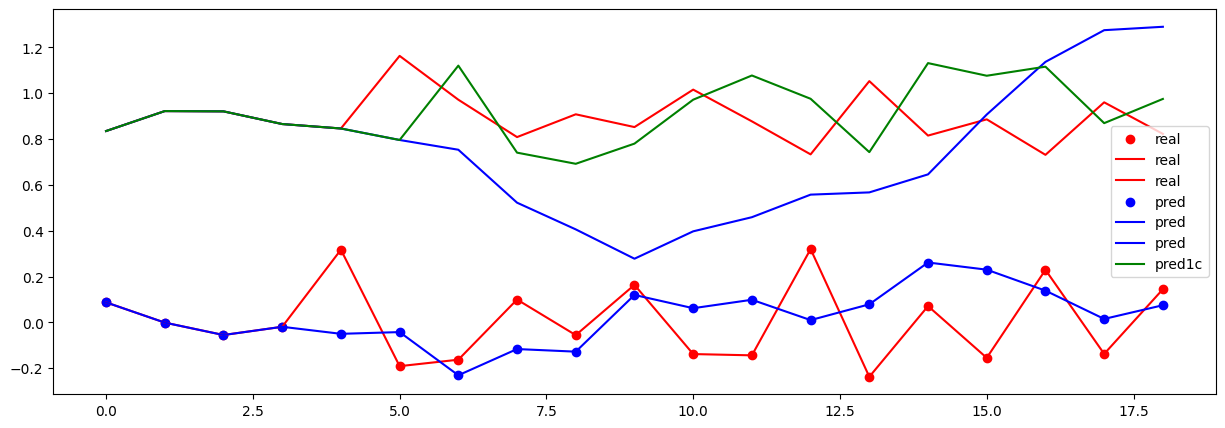

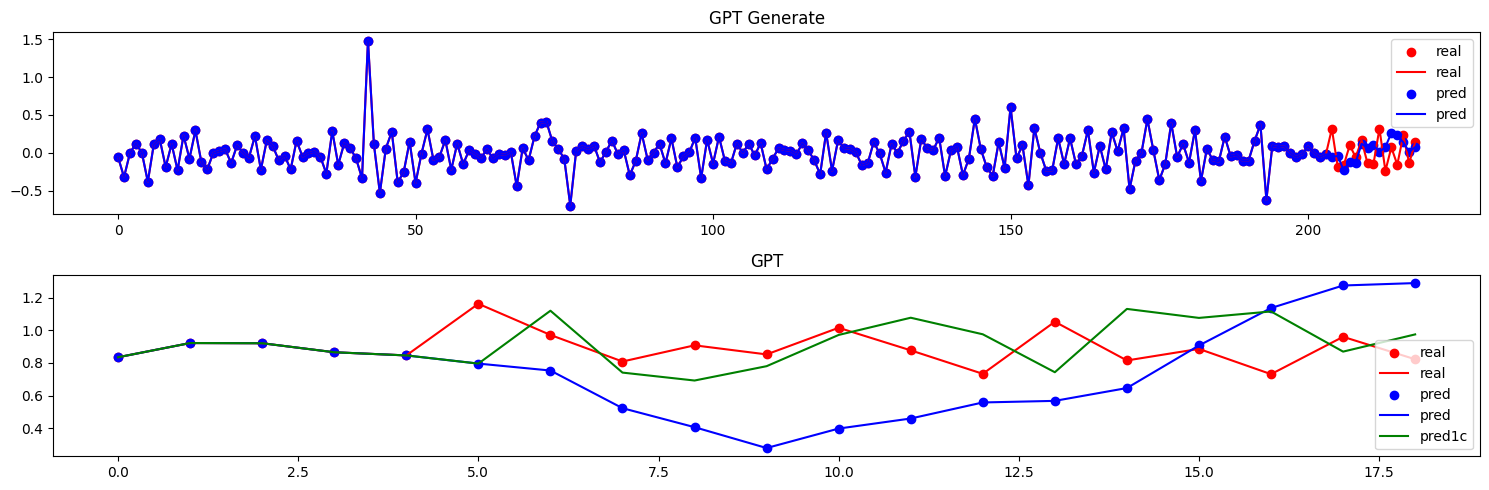

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



torch.Size([300, 25])
0 train loss =  1.1161154508590698
500 train loss =  0.013307983055710793


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


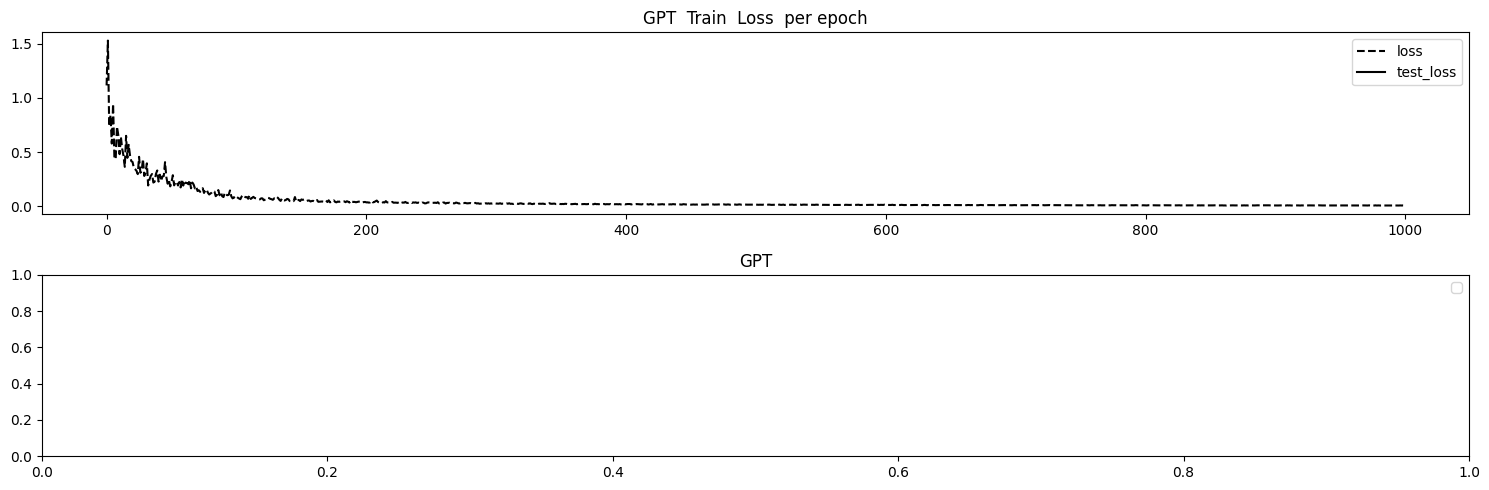

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03351058065891266
Test MSE Loss - SI only 0-5:  0.0030470683705061674
Test MSE Loss - SI only 5-10:  0.01524308044463396
Test MSE Loss - SI only 10-15:  0.048351019620895386
mae, mse, rmse, mape, mspe, rse, corr
(0.13778307, 0.03351058, 0.18305895, 4.8262997, 280.72443, 1.092523)
Testing R**2 - SI only:  -0.19360649585723877
Testing R**2 - SI only:  -0.19360649585723877
Testing R**2 - All features:  0.9924064874649048


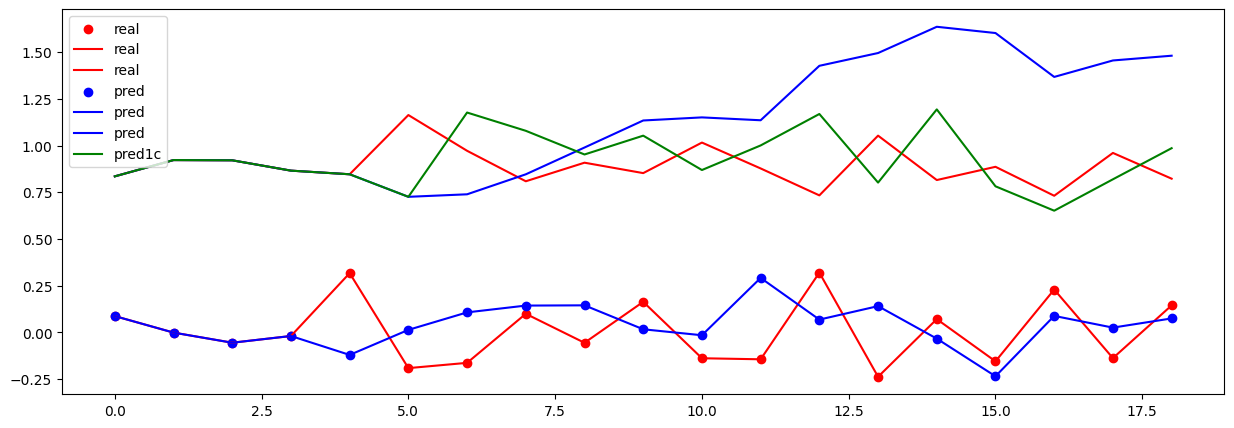

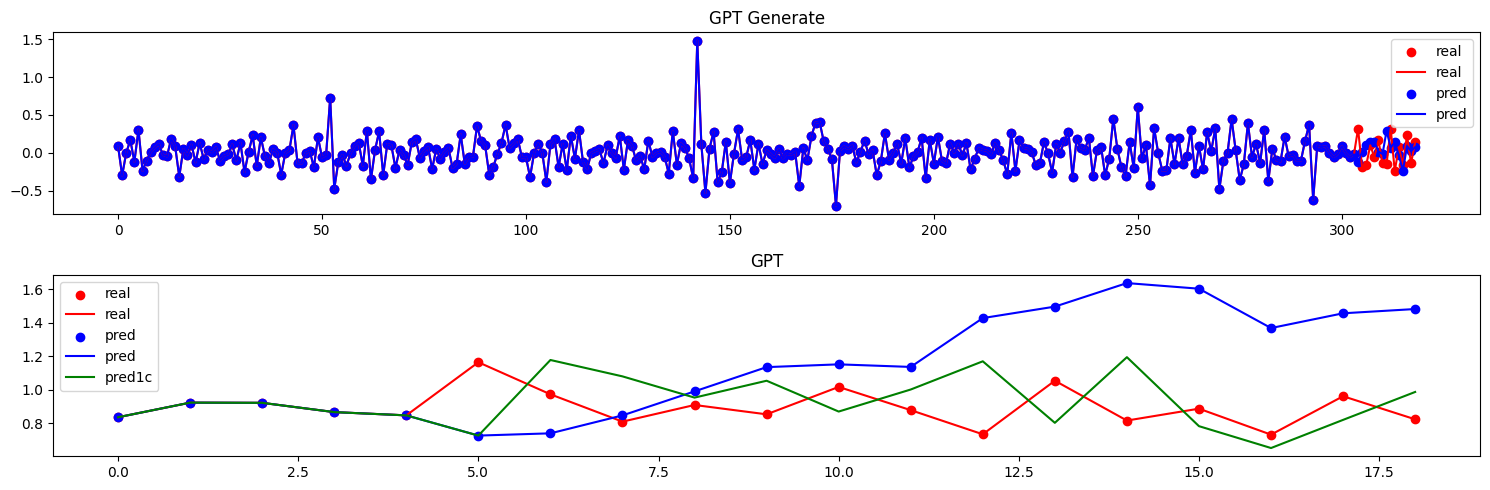

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


torch.Size([400, 25])
0 train loss =  1.18825101852417
500 train loss =  0.018465155735611916


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


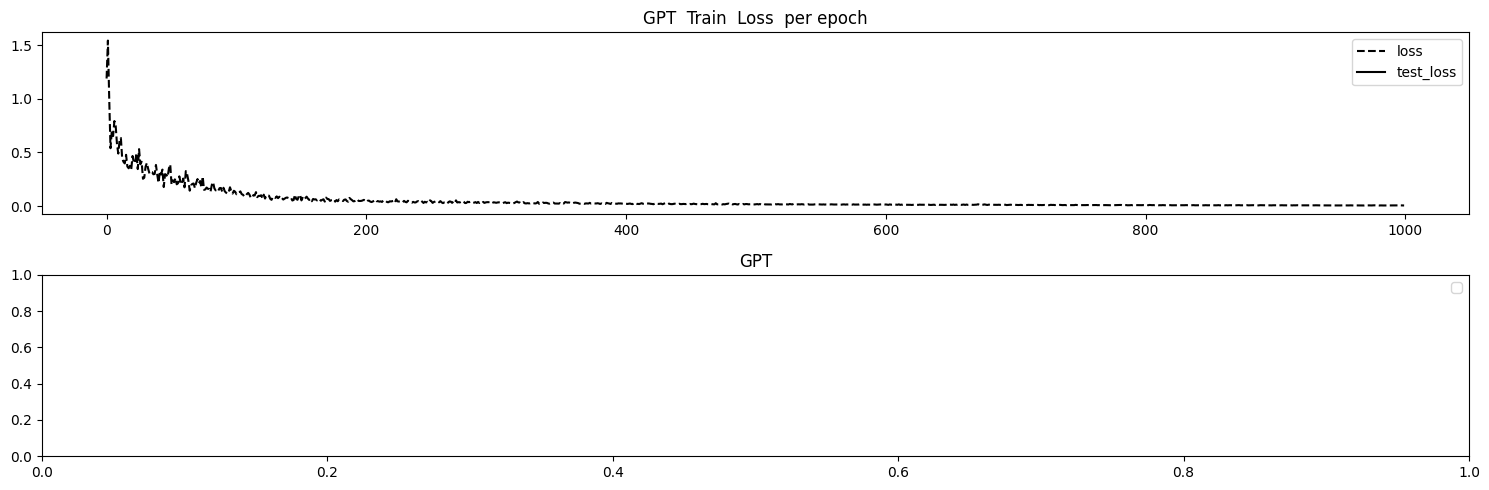

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
max tokens  14
torch.Size([1, 5, 25])
SI
Test MSE Loss - SI only:  0.03920751437544823
Test MSE Loss - SI only 0-5:  0.0030470683705061674
Test MSE Loss - SI only 5-10:  0.05114852264523506
Test MSE Loss - SI only 10-15:  0.04043041169643402
mae, mse, rmse, mape, mspe, rse, corr
(0.15868165, 0.03920751, 0.19800887, 5.017079, 281.4313, 1.1817462)
Testing R**2 - SI only:  -0.39652419090270996
Testing R**2 - SI only:  -0.39652419090270996
Testing R**2 - All features:  0.9860016703605652


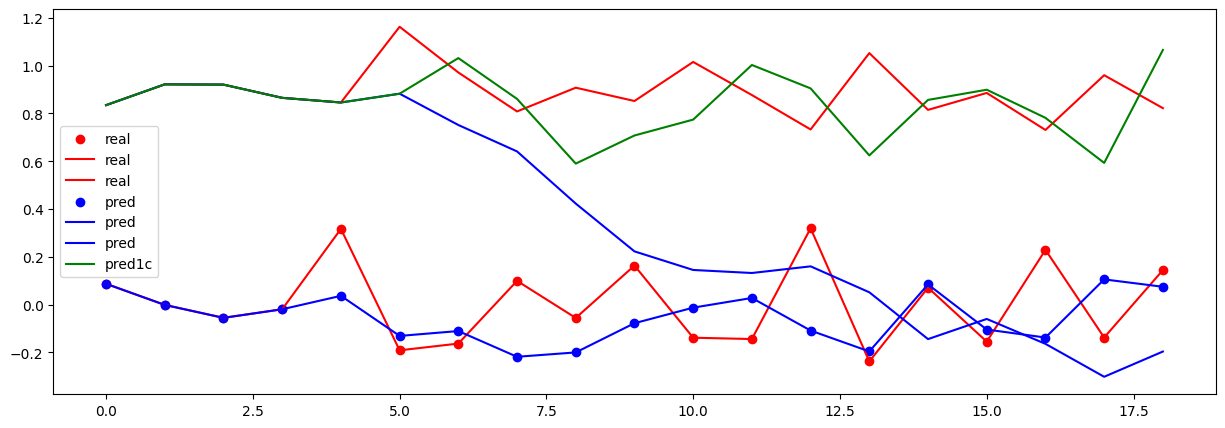

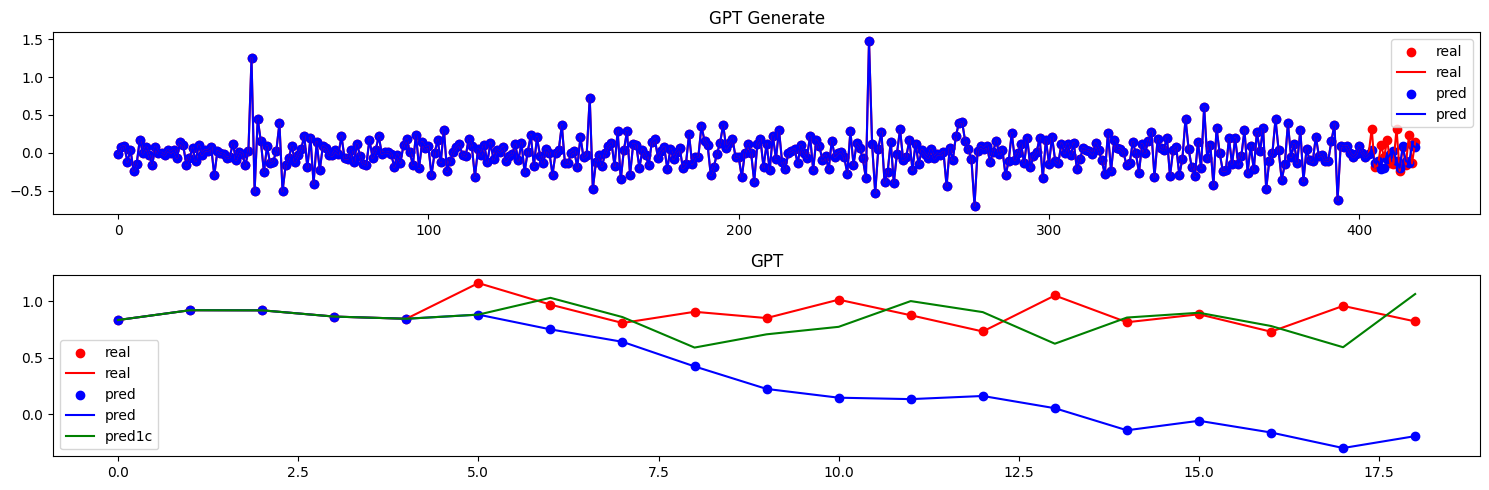

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
